### Make all the necessary imports 

In [1]:
import os
import cv2
import numpy as np
import time
from moviepy.editor import VideoFileClip
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from IPython.display import HTML
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
# from skimage.io import imread
%matplotlib inline
print('Modules Imported Successfully')

Modules Imported Successfully


### Make a list of images to read in

In [2]:
#images are divided up into vehicle and non-vehicle folders.
base_veh_dir = 'vehicles/'

# there are different types of images in different folders (e.g GIT, Kitti, etc..)
image_types = os.listdir(base_veh_dir)
cars = []
for imgtype in image_types:
    cars.extend(glob.glob(base_veh_dir+imgtype+'/*'))
print('The number of vehicle images found was: ', len(cars))

with open('cars.txt', 'w') as f:
    for fn in cars:
        f.write(fn+'\n')
        

#images are divided up into vehicle and non-vehicle folders.
base_veh_dir = 'non-vehicles/'

# there are different types of images in different folders (e.g GIT, Kitti, etc..)
image_types = os.listdir(base_veh_dir)
notcars = []
for imgtype in image_types:
    notcars.extend(glob.glob(base_veh_dir+imgtype+'/*'))
print('The number of non-vehicle images found was: ', len(notcars))

with open('notcars.txt', 'w') as f:
    for fn in cars:
        f.write(fn+'\n')

The number of vehicle images found was:  8792
The number of non-vehicle images found was:  8968


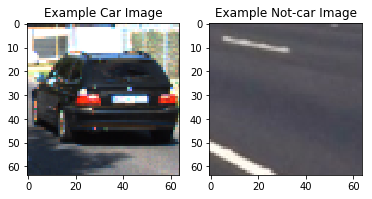

In [3]:
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.show()

### Define Features
Define some features used for classification.
- Spatial feature
- Color histogram features
- HOG features.

### Spatial Features
Reducing the size of the image was done by using the spatial binning function on an the image, which using the raw pixel values and flattens it into a feature vector

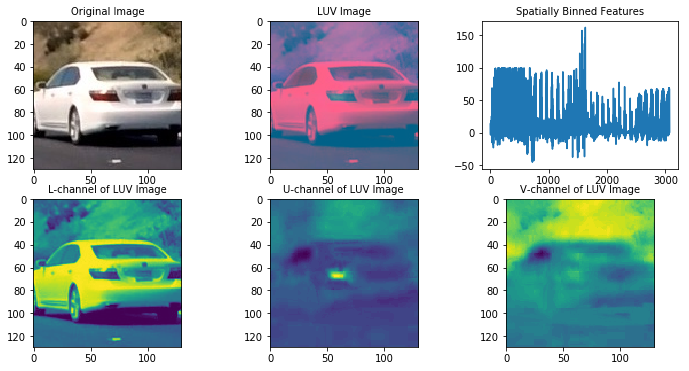

In [4]:
test_IMAGE = mpimg.imread('cutout11.jpg')
test_IMAGE_copy = np.copy(test_IMAGE)
small_img = cv2.resize(test_IMAGE, (32, 32))

def bin_spatial1(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

# size of the spacial bins
spatial_size = 32

# convert image to LUV color space
luv_image = cv2.cvtColor(test_IMAGE, cv2.COLOR_RGB2LUV)

# Extract spatial features, work on the saturation channel
feature_vec = bin_spatial1(car_image, color_space='LUV', size=(spatial_size, spatial_size))

# Visualize histogram
f, ((ax1, ax2, ax3), (ax4, ax5, ax6))= plt.subplots(2, 3, figsize=(12,6))
# original image
ax1.imshow(test_IMAGE_copy)
ax1.set_title('Original Image', fontsize=10)
# full LUV image
ax2.imshow(luv_image)
ax2.set_title('LUV Image', fontsize=10)
# spatially binned image
ax3.plot(feature_vec)
ax3.set_title('Spatially Binned Features', fontsize=10)
# L Channel
ax4.imshow(luv_image[:,:,0])
ax4.set_title('L-channel of LUV Image', fontsize=10)
# U Channel
ax5.imshow(luv_image[:,:,1])
ax5.set_title('U-channel of LUV Image', fontsize=10)
# V Channel
ax6.imshow(luv_image[:,:,2])
ax6.set_title('V-channel of LUV Image', fontsize=10)

### Histogram of Color
Now we'll look at histograms of pixel intensity 

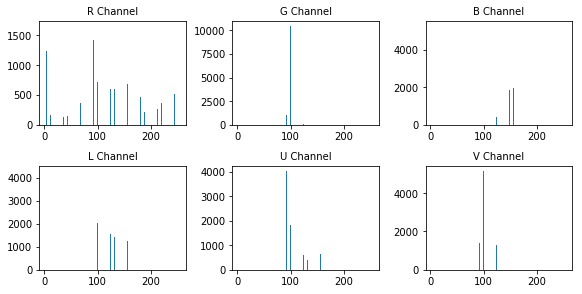

In [5]:
# Define a function to compute color histogram features  
def color_hist1(img, nbins=32, bins_range=(0,256)):
    # Compute the histogram of the RGB channels separately
    img_copy = np.copy(img)
    LUV_img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    channel1_hist = np.histogram(LUV_img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(LUV_img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(LUV_img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return channel1_hist, channel2_hist, channel3_hist, bin_centers, hist_features

nbins=32
# RGB color space
rh, gh, bh, bincen, feature_vec = color_hist1(test_IMAGE_copy, nbins=nbins)
# LUV color space
lh, uh, vh, bincen, feature_vec1 = color_hist1(luv_image, nbins=nbins)

# Visualize histogram
f, ((ax1, ax2,ax3),(ax4, ax5,ax6) )= plt.subplots(2, 3, figsize=(8,4))
# R Channel
ax1.bar(bincen, rh[0])
ax1.set_title('R Channel', fontsize=10)
# G Channel
ax2.bar(bincen, gh[0])
ax2.set_title('G Channel', fontsize=10)
# B Channel
ax3.bar(bincen, bh[0])
ax3.set_title('B Channel', fontsize=10)
# L Channel
ax4.bar(bincen, lh[0])
ax4.set_title('L Channel', fontsize=10)
# U Channel
ax5.bar(bincen, uh[0])
ax5.set_title('U Channel', fontsize=10)
# V Channel
ax6.bar(bincen, vh[0])
ax6.set_title('V Channel', fontsize=10)
plt.savefig('LUVHistogram.jpg')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

### HOG Features

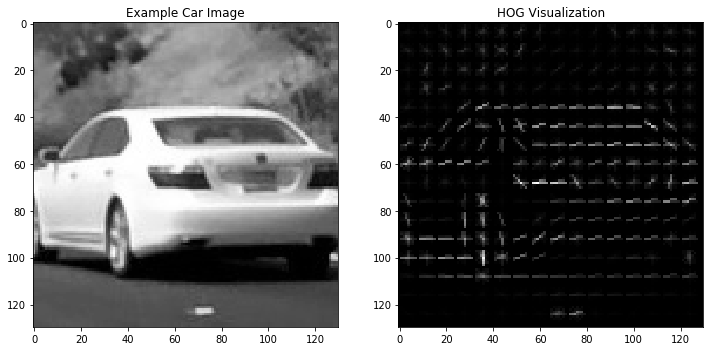

In [6]:
# Define a function to return HOG features and visualization
def get_hog_features1(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
gray = cv2.cvtColor(test_IMAGE, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 12
pix_per_cell = 8
cell_per_block = 1
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features1(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)


# Plot the examples
fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(gray, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

### Defining some useful functions 


In [7]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a single image window
def single_img_features(img, color_space, spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            if vis==True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis==True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)
    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features0 = cv2.resize(img[:,:,0], size).ravel()
    features1 = cv2.resize(img[:,:,1], size).ravel()
    features2 = cv2.resize(img[:,:,2], size).ravel() 
    # Return the feature vector
    return np.hstack((features0,features1,features2))

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

#define a function for plotting multipe images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

In [8]:
#Train the Linear SVM classifier
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t=time.time()
# uncomment below to use a sample of the cars/not-cars images for training
# n_samples = 1000
# random_indx=np.random.randint(0,len(cars),n_samples)
# test_cars = np.array(cars)[random_indx]
# test_notcars = np.array(notcars)[random_indx]

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print(time.time()-t, 'Seconds to compute features')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell', cell_per_block,'cells per block',
     hist_bins,'histogram bins, and', spatial_size,'spacial sampling')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

233.9579291343689 Seconds to compute features
Using: 9 orientations 8 pixels per cell 2 cells per block 32 histogram bins, and (32, 32) spacial sampling
Feature vector length: 8460
37.72 Seconds to train SVC...
Test Accuracy of SVC =  0.9938


In [9]:
#Function to scroll through the image using x y coordinates
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [10]:
# Gets an image from slide_window and lists all the windows to be serch for.
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    on_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)
        if prediction == 1:
            on_windows.append(window)
    return on_windows

In [11]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(255, 0, 0), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

1.322220802307129 seconds to process on image searching 100 windows
1.240159034729004 seconds to process on image searching 100 windows
1.5283188819885254 seconds to process on image searching 100 windows
1.357921838760376 seconds to process on image searching 100 windows
1.3328380584716797 seconds to process on image searching 100 windows
1.386998176574707 seconds to process on image searching 100 windows


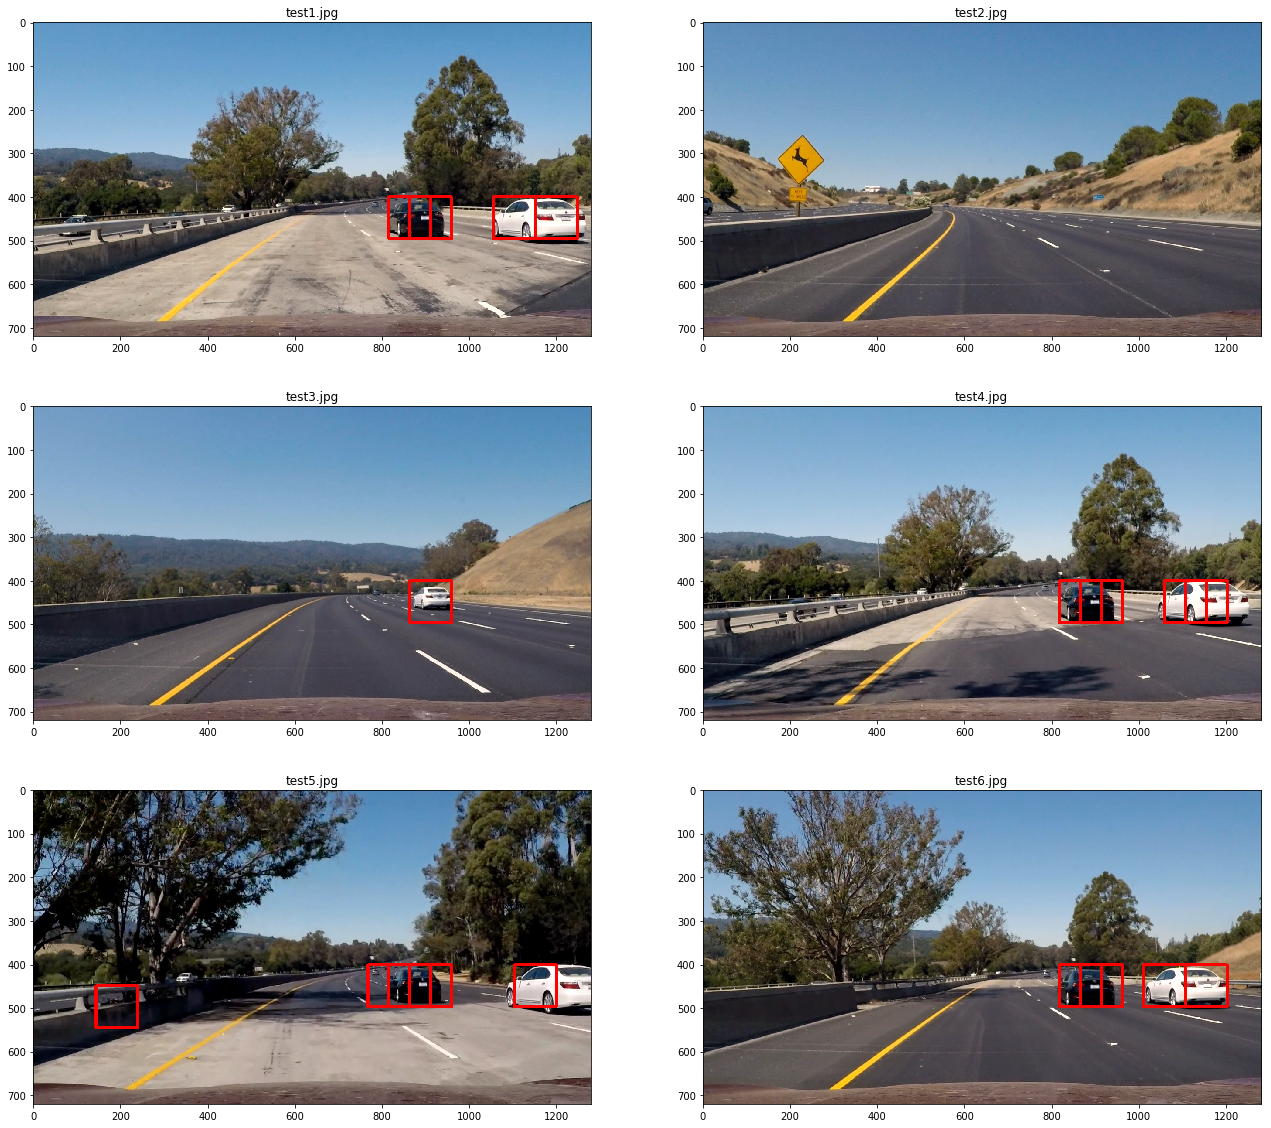

In [12]:
#test on test images
test_images = glob.glob('./test_images/*')
images = []
titles = []
y_start_stop=[400, 656]
overlap = 0.5

for img_src in test_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(overlap, overlap))
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat)
    
    window_img = draw_boxes(draw_img,hot_windows,color=(255,0,0),thick=6)
    images.append(window_img)
    titles.append(img_src[-9:])
    print(time.time()-t1,'seconds to process on image searching',len(windows),'windows')
fig = plt.figure(figsize=(22,20))
visualize(fig,3,2,images,titles)

In [13]:
# converting color spaces

def convert_color(img, conv='RGB2YCrCb'):
    if conv=='RGB2YCrCb':
        return cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)
    if conv=='BGR2YCrCb':
        return cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb)
    if conv=='RGB2LUV':
        return cv2.cvtColor(img,cv2.COLOR_RGB2LUV)

0.857490062713623 seconds to run, total windows =  294
0.9657928943634033 seconds to run, total windows =  294
1.7890400886535645 seconds to run, total windows =  294
1.1297481060028076 seconds to run, total windows =  294
0.9228949546813965 seconds to run, total windows =  294
0.9720959663391113 seconds to run, total windows =  294


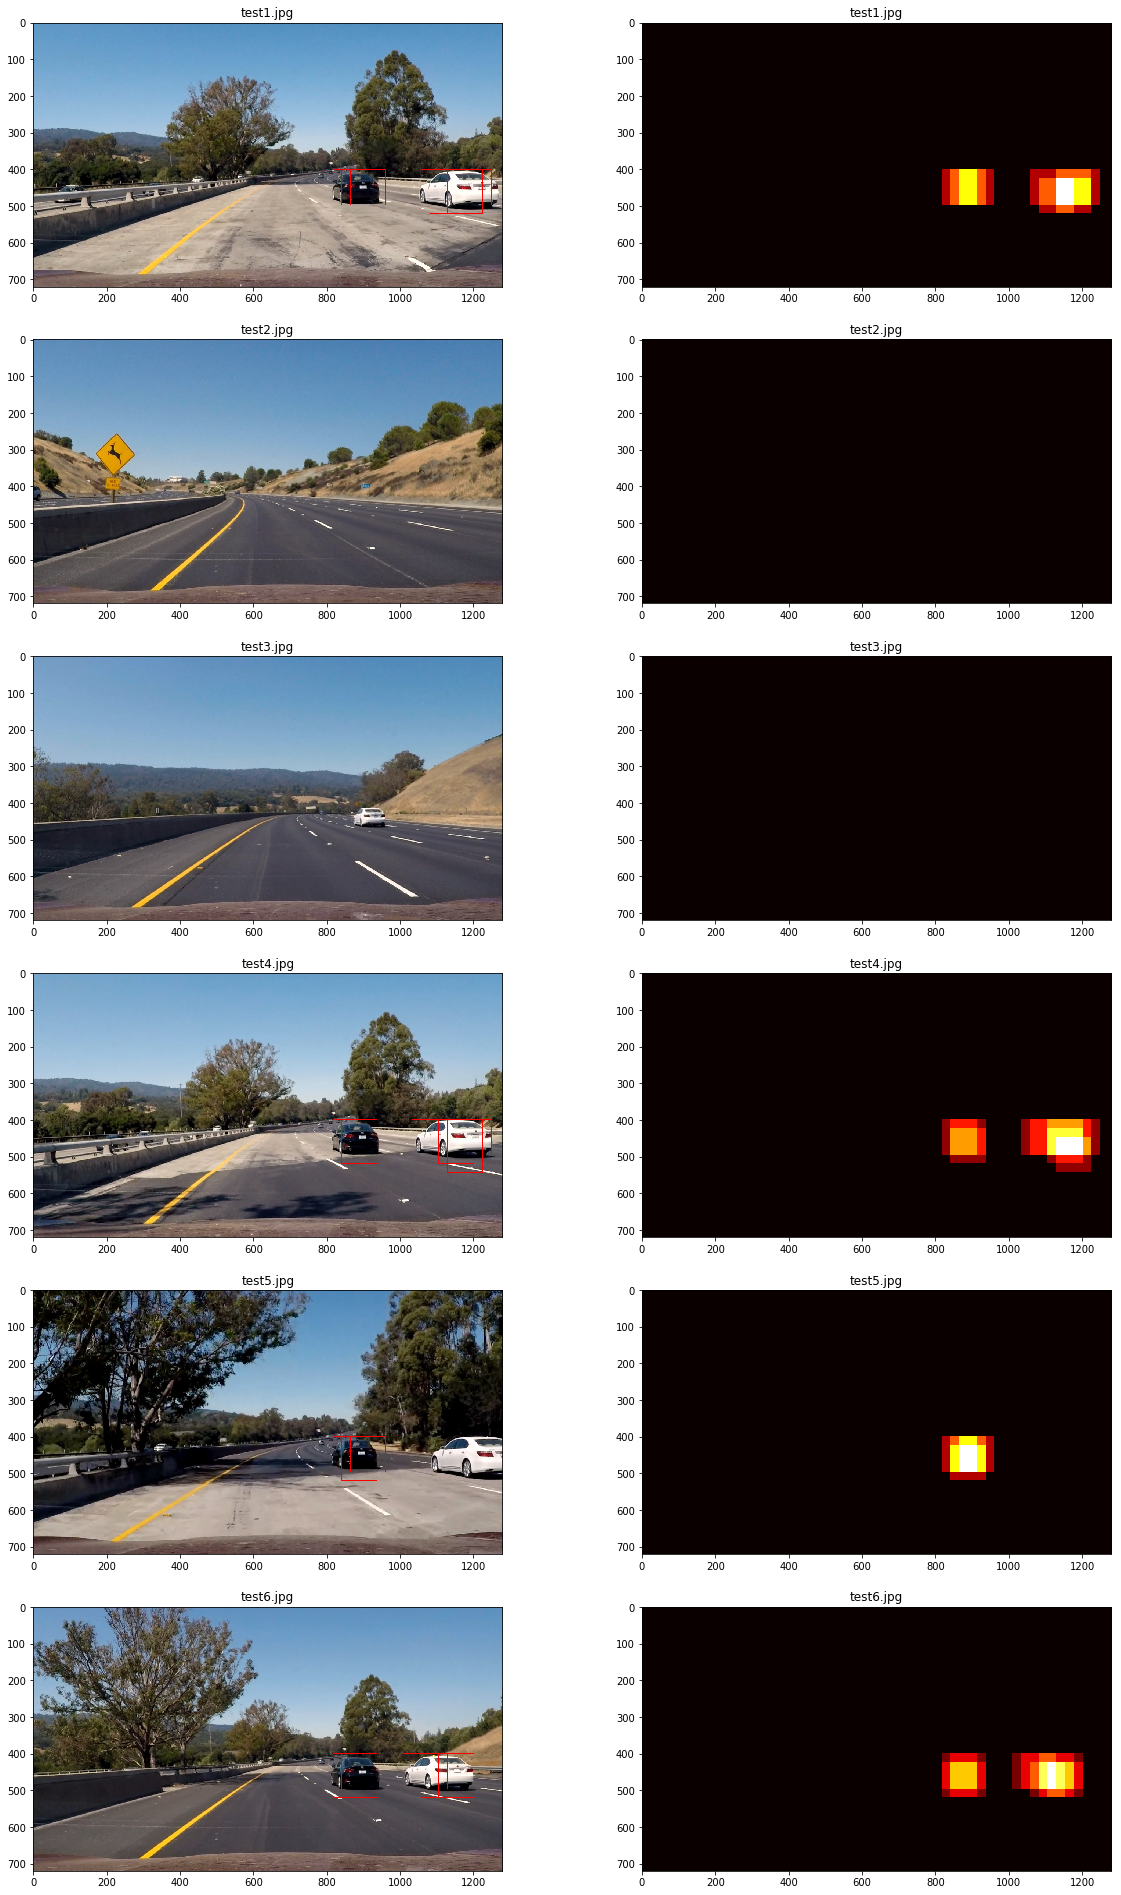

In [14]:
#implement heat map
test_images = glob.glob('./test_images/*')
out_images = []
out_maps = []
out_titles = []
out_boxes = []
ystart = 400
ystop = 655
scale = 1.5

for img_src in test_images:
    img_boxes = []
    t = time.time()
    count = 0
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    #heat map
    heatmap = np.zeros_like(img[:,:,0])
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
        
    #define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
        
    ##compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec = False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec = False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec = False)
        
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            #Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1,hog_feat2,hog_feat3))
                
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
                
            #Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window,xleft:xleft+window], (64,64))
                
            #get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
                
            #scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features,hist_features,hog_features)).reshape(1,-1))
            test_prediction = svc.predict(test_features)
                
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart),(255,0,0))
                img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart,xbox_left:xbox_left+win_draw] += 1
                    
    print(time.time()-t, 'seconds to run, total windows = ', count)
        
    out_images.append(draw_img)
    out_titles.append(img_src[-9:])
    out_titles.append(img_src[-9:])
        
    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)
        
fig = plt.figure(figsize=(20,34))
visualize(fig,6,2,out_images,out_titles)

In [15]:
def find_cars(img, scale):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    #heat map
    heatmap = np.zeros_like(img[:,:,0])
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
        
    #define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
        
    ##compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec = False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec = False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec = False)
        
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            #Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1,hog_feat2,hog_feat3))
                
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
                
            #Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window,xleft:xleft+window], (64,64))
                
            #get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
                
            #scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features,hist_features,hog_features)).reshape(1,-1))
            test_prediction = svc.predict(test_features)
                
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255))
                img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart,xbox_left:xbox_left+win_draw] += 1
                    
    return draw_img, heatmap

def draw_labeled_bboxes(img,labels):
    #iterative all detected cars
    for car_number in range(1,labels[1]+1):
        #find pixes with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        #Identify x and y values of those labels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        #define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox),np.min(nonzeroy)),(np.max(nonzerox),np.max(nonzeroy)))
        #draw the box on the image
        cv2.rectangle(img,bbox[0],bbox[1],(255,0,0),6)
    return img

In [16]:
class Image():
    def __init__(self):
        self.sumheat_map = []
        
    def process_image(self,img):
        scale = 1.5
        out_img, heat_map = find_cars(img, scale)
        self.sumheat_map.append(heat_map)
        if len(self.sumheat_map) > 10:
            self.sumheat_map.pop(0)
        #heat_map = pre_heat_map * 0.8 + heat_map * 0.2
        heat_map = apply_threshold(sum(self.sumheat_map), 5)
        labels = label(heat_map)
        #draw bounding box on a copy of the image
        draw_img = draw_labeled_bboxes(np.copy(img),labels)
        #pre_heat_map = heat_map
        return draw_img

In [17]:
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

In [18]:
# test video
video = Image()
from moviepy.editor import VideoFileClip
from IPython.display import HTML
test_output = 'test_video_solution.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(video.process_image)
%time white_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_video_solution.mp4
[MoviePy] Writing video test_video_solution.mp4


 97%|█████████▋| 38/39 [00:36<00:00,  1.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_solution.mp4 

CPU times: user 30.2 s, sys: 1.26 s, total: 31.5 s
Wall time: 40.3 s


In [19]:
# project video
video = Image()
test_output = 'project_video_solution.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(video.process_image)
%time white_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video project_video_solution.mp4
[MoviePy] Writing video project_video_solution.mp4


100%|█████████▉| 1260/1261 [24:26<00:01,  1.35s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_solution.mp4 

CPU times: user 16min 49s, sys: 39.1 s, total: 17min 28s
Wall time: 24min 32s
